In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
df =pd.read_csv('/content/drive/My Drive/FODS/insurance.txt')
df.head()

Mounted at /content/drive


,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


In [ ]:
%matplotlib inline

In [ ]:
df2 = df[df['children'] == 0] #conditional filtering for visualization
fig = px.scatter_3d(df, z="charges" , 
                                   y='bmi', 
                                   x='age',
                                  size=[0.5 for i in range(len(df['charges']))],
                                  color='children'
                                   );
fig.update_layout(title='comparison graph', autosize=False)
fig.update_traces(marker=dict(size=2,))

In [ ]:
ageMin,ageMax ,BMImin, BMImax = np.min(df['age']),np.max(df['age']), np.min(df['bmi']), np.max(df['bmi'])
ages = np.linspace(ageMin, ageMax, 100)
bmis = np.linspace(BMImin, BMImax, 100)

ages = (ages- ages.min())/(ages.max() - ages.min())
bmis = (bmis - bmis.min())/(bmis.max() - bmis.min())

dataInputs = np.meshgrid(ages,bmis)
dataInputs = np.array(dataInputs).reshape(2,10000)
dataInputs = dataInputs.T

In [ ]:
def splitUtil(sample, degree):
  X_dataset = sample.iloc[:, 0:-1]
  y_dataset = sample.iloc[:, -1]

  poly = PolynomialFeatures(degree=degree, include_bias=False)
  X_dataset = poly.fit_transform(X_dataset)
  X_dataset = (X_dataset - X_dataset.min()) / (X_dataset.max() - X_dataset.min())
  y_dataset = (y_dataset - y_dataset.min()) / (y_dataset.max() - y_dataset.min())

  y_dataset = np.array(y_dataset).reshape(-1,1)
  return X_dataset, y_dataset

In [ ]:
def split(df, frac_train, frac_test, degree=2):
    # train, test, validate = np.split(df.drop('children', axis=1).sample(frac=1), [int(frac_train*len(df)), int((frac_train + frac_test)*len(df))])
                                                                                  #
    train, test, validate = np.split(df.drop('children',axis = 1).reindex(np.random.RandomState(seed=413).permutation(df.index)), [int(frac_train*len(df)), int((frac_train + frac_test)*len(df))])
    
    X_train, y_train = splitUtil(train, degree)

    X_validate, y_validate = splitUtil(validate, degree)

    X_test, y_test = splitUtil(test, degree)
    
    return X_train, y_train, X_test, y_test, X_validate, y_validate

In [ ]:
def mse(coeff, bias, X, y):
  pred = np.dot(X, coeff) + bias
  return (1/(y.shape[0] * 2))*np.sum(((y) - (pred))**2)

# **SGD**

In [ ]:
def ridge_SGD(W, b, X, y, lamb):
    X.reshape(-1,1)
    grad_w = np.array(X * (X.dot(W) + b - y) ).reshape(-1,1)  + lamb*(W) #6, 
    grad_b = (X.dot(W) + b - y).item(0)
    return grad_w, grad_b

def lasso_SGD(W, b, X, y, lamb):
    X.reshape(-1,1)
    grad_w = np.array(X * (X.dot(W) + b - y) ).reshape(-1,1)  + lamb*np.sign(W) #6, 
    grad_b = (X.dot(W) + b - y).item(0) #1x6 6x1 1x1 
    return grad_w, grad_b

def SGD(X_train, y_train, X_test, y_test, alpha = 0.01, reg = 'ridge', lamb = 0, epochs = 1000, gitgraph = False):
    X = X_train
    y = y_train
    W = np.random.rand(X.shape[1], 1) * 0.01 
    b = 1 #1300x4 4x1 
    mse_train = np.zeros((epochs,))
    mse_test = np.zeros((epochs,))
    if reg == 'ridge':
        grad_SGD = ridge_SGD
    elif reg == 'lasso':
        grad_SGD = lasso_SGD

    for j in range(epochs):
        i = randint(0,len(X)-1)
        grad_w , grad_b = grad_SGD(W, b, X[i], y[i], lamb)
        W = W - alpha * grad_w
        b = b - alpha * grad_b
        
        if gitgraph:
              mse_train[j] = mse(W, b, X_train, y_train)
              
              mse_test[j] = mse(W, b, X_test, y_test)
        if j % 50 == 0:
            pass
            # print(((np.dot(X, W) - y) ** 2).sum())
    if gitgraph:
      return W, b, mse_train, mse_test
    return W, b

# **GD**

In [ ]:
def ridge_GD(W, b, X, y, lamb):
    grad_w = (X.T.dot(X.dot(W) + b - y) + np.sum(lamb*(W)))        # d 1/2*(xW-y)**2 / dW  --> (xW-y)*X --> (ab)T = bTaT
    grad_b = np.sum(X.dot(W) + b - y)
    return grad_w, grad_b

def lasso_GD(W, b, X, y, lamb):
    grad_w = (X.T.dot(X.dot(W) + b - y) + np.sign(lamb*(W)))        # d 1/2*(xW-y)**2 / dW  --> (xW-y)*X --> (ab)T = bTaT
    grad_b = np.sum(X.dot(W) + b - y)
    return grad_w, grad_b

def GD(X_train, y_train, X_test, y_test, alpha = 0.01, reg = 'ridge', lamb = 0, epochs = 1000, gitgraph = False):
    X = X_train
    y = y_train  
    mse_train = np.zeros((epochs,))
    mse_test = np.zeros((epochs,))
    b = 1
    W = np.random.rand(X.shape[1], 1) * 0.01
    if reg == 'ridge':
        grad_GD = ridge_GD
    elif reg == 'lasso':
        grad_GD = lasso_GD
    for j in range(epochs):
        grad_w, grad_b = grad_GD(W, b, X, y, lamb)
        W = W - alpha/len(X) * grad_w
        b = b - alpha/len(X) * grad_b
        if gitgraph:
            mse_train[j] = mse(W, b, X_train, y_train)
            mse_test[j] = mse(W, b, X_test, y_test)
      # if j % 50 == 0:
      #     print(((np.dot(X, W) - y) ** 2).sum())
    if gitgraph:
        return W, b, mse_train, mse_test
    return W, b

In [ ]:
def error_epoch(degrees = 10, alpha= 0.01, epochs=100, lamb=0.001):
  for degree in range(1,degrees+1):
    X_train, y_train, X_test, y_test, X_validate, y_validate = split(df, 0.7, 0.1, degree=degree)
    coeff, bias, error_train, error_test = GD(X_train, y_train, X_validate, y_validate,alpha=alpha, epochs = epochs, lamb = lamb, gitgraph=True)
    coeff, bias, error_train, error_test = SGD(X_train, y_train, X_validate, y_validate,alpha=alpha,epochs = epochs, lamb = lamb,gitgraph=True)
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    print(poly)
    global dataInputs, ages, bmis

    x_ = np.array(poly.fit_transform(dataInputs)) #10000x2 -> 10000xn
    z = x_.dot(coeff) + bias #10000x1
    z = z.reshape(100,100)
    fig = go.Figure(data=[go.Surface(x=ages, y=bmis, z=z)])
    
    fig.update_layout(
    scene=dict(xaxis=dict(title=dict(text='age')),
               yaxis=dict(title=dict(text='bmi')),
               zaxis=dict(title=dict(text='insurance'))),
    autosize=False,
    width=500,
    height=300,
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor='LightSteelBlue',
    )
    fig.show() 


In [ ]:
np.seterr(invalid='raise')
error_epoch(degrees = 10, lamb=1, epochs=500, alpha=0.01)

PolynomialFeatures(degree=1, include_bias=False, interaction_only=False,
                   order='C')


PolynomialFeatures(degree=2, include_bias=False, interaction_only=False,
                   order='C')


PolynomialFeatures(degree=3, include_bias=False, interaction_only=False,
                   order='C')


PolynomialFeatures(degree=4, include_bias=False, interaction_only=False,
                   order='C')


PolynomialFeatures(degree=5, include_bias=False, interaction_only=False,
                   order='C')


PolynomialFeatures(degree=6, include_bias=False, interaction_only=False,
                   order='C')


PolynomialFeatures(degree=7, include_bias=False, interaction_only=False,
                   order='C')


PolynomialFeatures(degree=8, include_bias=False, interaction_only=False,
                   order='C')


PolynomialFeatures(degree=9, include_bias=False, interaction_only=False,
                   order='C')


PolynomialFeatures(degree=10, include_bias=False, interaction_only=False,
                   order='C')


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
def eval_degrees(regression_func, degrees = 10):
    mse_train_list = np.zeros((degrees,))
    mse_test_list = np.zeros((degrees,))
    mse_val_list = np.zeros((degrees,))
    for degree in range(1, degrees+1):
        X_train, y_train, X_test, y_test, X_validate, y_validate = split(df, 0.7, 0.1, degree=degree)
        W, b, mse_train, mse_validate = regression_func(X_train, y_train, X_validate, y_validate, gitgraph=True)
        mse_train_list[degree-1] = mse_train[-1]
        mse_val_list[degree-1] = mse_validate[-1]
        mse_test_list[degree-1] = mse(W,b,X_test,y_test)

    a1, = plt.plot(mse_train_list, label='train_list')
    a2, = plt.plot(mse_test_list, label='val_list')
    a3, = plt.plot(mse_val_list, label='test_list')
    h = [a1,a2,a3]
    plt.legend(handles=h)
    plt.show()
    return np.argmin(mse_train_list) + 1, np.min(mse_train_list), np.argmin(mse_test_list) + 1, np.min(mse_test_list);

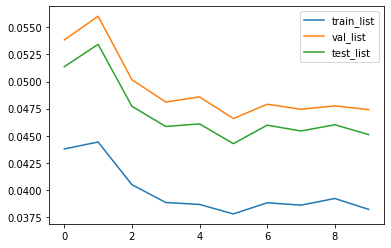

(6, 0.03780502171125537, 6, 0.0465893107758956)

In [ ]:
eval_degrees(SGD, 10)

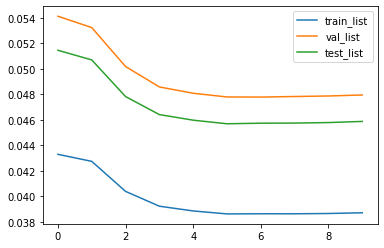

(6, 0.03862793784473149, 7, 0.04779460172340425)

In [ ]:
eval_degrees(GD, 10)

In [ ]:
lamb_list = np.random.uniform(0,1,10)
lamb_list

array([0.41923661, 0.34312879, 0.30644879, 0.52291654, 0.5518963 ,
       0.65016782, 0.90634647, 0.2625988 , 0.93628298, 0.74893447])

In [ ]:
def eval_reg(regression_func, reg, lamb_list, degrees = 10):
    mse_train_deg = []
    mse_validation_deg = []
    mse_test_deg = []
    for degree in range(1, degrees+1):
        mse_train_lamb = np.zeros((len(lamb_list), ))
        mse_validation_lamb = np.zeros((len(lamb_list), ))
        mse_test_lamb = np.zeros((len(lamb_list), ))
        X_train, y_train, X_test, y_test, X_validate, y_validate = split(df, 0.7, 0.1, degree=degree)
        for i in range(len(lamb_list)):
            W, b, mse_train, mse_validation = regression_func(X_train, y_train, X_validate, y_validate, reg=reg, lamb=lamb_list[i], gitgraph=True)
            mse_train_lamb[i] = mse_train[-1]
            mse_validation_lamb[i] = mse_validation[-1]
            mse_test_lamb[i] = mse(W,b,X_test,y_test)
        mse_train_deg.append(( np.min(mse_train_lamb), lamb_list[np.argmin(mse_train_lamb)] ))
        mse_validation_deg.append(( np.min(mse_validation_lamb), lamb_list[np.argmin(mse_validation_lamb)] ))
        mse_test_deg.append(( np.min(mse_test_lamb), lamb_list[np.argmin(mse_test_lamb)] ))
    mse_train_deg = np.array(mse_train_deg)
    mse_validation_deg = np.array(mse_validation_deg)
    mse_test_deg = np.array(mse_test_deg)
    # print(np.hstack((mse_train_deg[:,0].reshape(-1,1),mse_test_deg[:,0].reshape(-1,1))))
    print(mse_train_deg)
    print(mse_validation_deg)
    print(mse_test_deg)

    return np.argmin(mse_train_deg[:,0]) + 1, np.min(mse_train_deg),np.argmin(mse_validation_deg[:,0]) + 1, np.min(mse_validation_deg), np.argmin(mse_test_deg[:,0]) + 1, np.min(mse_test_deg)

In [ ]:
print('min_error \t lambda')
print('deg, min_train_err \t deg, min_validation_err \t deg, min_test_err\n', eval_reg(GD, 'lasso', lamb_list, degrees=10))

min_error 	 lambda
[[0.04280411 0.52291654]
 [0.04227397 0.30644879]
 [0.03993326 0.65016782]
 [0.0389275  0.2625988 ]
 [0.03860345 0.74893447]
 [0.03852209 0.41923661]
 [0.03854197 0.74893447]
 [0.03859167 0.93628298]
 [0.03863381 0.93628298]
 [0.03867704 0.30644879]]
[[0.05081734 0.52291654]
 [0.05009952 0.30644879]
 [0.04723606 0.65016782]
 [0.04602996 0.2625988 ]
 [0.04566133 0.93628298]
 [0.04556819 0.41923661]
 [0.0456116  0.74893447]
 [0.04569348 0.93628298]
 [0.04576294 0.93628298]
 [0.04583198 0.30644879]]
[[0.05346151 0.52291654]
 [0.05258605 0.30644879]
 [0.04955949 0.65016782]
 [0.04813455 0.34312879]
 [0.04771842 0.74893447]
 [0.04767855 0.41923661]
 [0.04774122 0.52291654]
 [0.04783194 0.93628298]
 [0.04790973 0.93628298]
 [0.04798177 0.30644879]]
deg, min_train_err 	 deg, min_validation_err 	 deg, min_test_err
 (6, 0.038522090898324216, 6, 0.045568190492650776, 6, 0.0476785509549279)


In [ ]:
print('min_error \t lambda')
print('deg, min_train_err \t deg, min_test_err\n', eval_reg(GD, 'ridge', lamb_list, degrees=10))

min_error 	 lambda
[[0.04311409 0.34312879]
 [0.04260244 0.93628298]
 [0.04020804 0.52291654]
 [0.03916597 0.52291654]
 [0.03876491 0.93628298]
 [0.038614   0.41923661]
 [0.03856375 0.34312879]
 [0.03857729 0.34312879]
 [0.03863202 0.34312879]
 [0.03867023 0.52291654]]
[[0.0512229  0.34312879]
 [0.05051251 0.93628298]
 [0.04759403 0.52291654]
 [0.0463261  0.52291654]
 [0.04585463 0.93628298]
 [0.04568013 0.2625988 ]
 [0.04563379 0.34312879]
 [0.04566262 0.34312879]
 [0.04575298 0.34312879]
 [0.0458157  0.52291654]]
[[0.05389975 0.34312879]
 [0.05307535 0.93628298]
 [0.04994737 0.52291654]
 [0.04852956 0.52291654]
 [0.04795109 0.2625988 ]
 [0.04774752 0.41923661]
 [0.04772084 0.34312879]
 [0.04776201 0.34312879]
 [0.04784387 0.34312879]
 [0.04793862 0.52291654]]
deg, min_train_err 	 deg, min_test_err
 (7, 0.0385637463808445, 7, 0.0456337901538703, 7, 0.04772083684075106)


In [ ]:
print('min_error \t lambda')
print('deg, min_train_err \t deg, min_test_err\n', eval_reg(SGD, 'lasso', lamb_list, degrees=10))

min_error 	 lambda
[[0.03924625 0.90634647]
 [0.03946693 0.74893447]
 [0.03925082 0.93628298]
 [0.03932945 0.65016782]
 [0.03927993 0.5518963 ]
 [0.03953938 0.5518963 ]
 [0.03941676 0.65016782]
 [0.03942198 0.52291654]
 [0.03961602 0.93628298]
 [0.03947091 0.93628298]]
[[0.04652836 0.90634647]
 [0.04691231 0.34312879]
 [0.04655756 0.93628298]
 [0.04673231 0.34312879]
 [0.04663628 0.5518963 ]
 [0.04685156 0.34312879]
 [0.0466957  0.93628298]
 [0.04672617 0.52291654]
 [0.04687748 0.65016782]
 [0.04680519 0.5518963 ]]
[[0.04845028 0.90634647]
 [0.04856736 0.34312879]
 [0.04824467 0.5518963 ]
 [0.04835398 0.34312879]
 [0.0483885  0.5518963 ]
 [0.04843278 0.34312879]
 [0.04821547 0.93628298]
 [0.04844198 0.65016782]
 [0.04844587 0.5518963 ]
 [0.04837154 0.5518963 ]]
deg, min_train_err 	 deg, min_test_err
 (1, 0.039246249126114366, 1, 0.04652835546723487, 7, 0.04821546886993098)


In [ ]:
print('min_error \t lambda')
print('deg, min_train_err \t deg, min_test_err\n', eval_reg(SGD, 'ridge', lamb_list, degrees=10))

min_error 	 lambda
[[0.03883567 0.41923661]
 [0.03867169 0.5518963 ]
 [0.03822168 0.41923661]
 [0.03845404 0.41923661]
 [0.03858056 0.34312879]
 [0.03824804 0.30644879]
 [0.03858438 0.30644879]
 [0.03860341 0.2625988 ]
 [0.03878188 0.41923661]
 [0.03907227 0.52291654]]
[[0.0457392  0.90634647]
 [0.04541661 0.65016782]
 [0.04507532 0.41923661]
 [0.04519778 0.41923661]
 [0.04522742 0.2625988 ]
 [0.04518825 0.30644879]
 [0.04568593 0.30644879]
 [0.04558157 0.2625988 ]
 [0.04574661 0.2625988 ]
 [0.04605579 0.2625988 ]]
[[0.04744852 0.90634647]
 [0.04715914 0.65016782]
 [0.04712739 0.52291654]
 [0.04718626 0.41923661]
 [0.04717457 0.2625988 ]
 [0.0473739  0.30644879]
 [0.04779165 0.30644879]
 [0.04765931 0.2625988 ]
 [0.04770611 0.2625988 ]
 [0.04790637 0.2625988 ]]
deg, min_train_err 	 deg, min_test_err
 (3, 0.03822167521578206, 3, 0.04507531738908682, 3, 0.047127389389247945)
